<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2025/blob/main/Week7_NeuroFuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 Colab: Neuro-Fuzzy Advantage — Visual Evidence
## NN vs Neuro-Fuzzy (lower cart drift + lower pole oscillation)

### What is this code?
In addition to MP4 videos, we add **clear visual plots** to demonstrate Neuro-Fuzzy advantages:

- Time-series plots: `x(t)` and `|theta(t)|`
- Comparison plots: NN vs Neuro-Fuzzy vs Teacher
- Metric bar charts / distributions across seeds

This helps you *explicitly* show that Neuro-Fuzzy is smoother (smaller drift and oscillation).


## 0. Setup

In [ ]:
!pip -q install gymnasium torch
!apt-get -qq install -y ffmpeg


In [ ]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
from google.colab import files

np.random.seed(0)
torch.manual_seed(0)


## 1. Teacher policy (interpretable, includes x-correction)

In [ ]:
def triangular_mf_np(x, a, b, c):
    x = np.asarray(x, dtype=float)
    left = (x - a) / (b - a + 1e-12)
    right = (c - x) / (c - b + 1e-12)
    return np.maximum(np.minimum(left, right), 0.0)

# θ MFs (signed)
theta_neg  = (-0.5, -0.2, 0.0)
theta_zero = (-0.15, 0.0, 0.15)
theta_pos  = (0.0, 0.2, 0.5)

# θ_dot MFs (signed)
tdot_neg  = (-4.0, -1.5, 0.0)
tdot_zero = (-0.8, 0.0, 0.8)
tdot_pos  = (0.0, 1.5, 4.0)

# x MFs (signed) for center correction
x_neg  = (-2.4, -1.2, 0.0)
x_zero = (-0.5, 0.0, 0.5)
x_pos  = (0.0, 1.2, 2.4)

def signed_tendency_from_params(val, neg_p, zero_p, pos_p):
    muN = float(triangular_mf_np(val, *neg_p))
    muP = float(triangular_mf_np(val, *pos_p))
    return muP - muN

TEACHER_K = 0.5
TEACHER_KX = 1.2  # explicit center correction strength

def teacher_policy(obs):
    x = float(obs[0])
    theta = float(obs[2])
    tdot = float(obs[3])

    tend_theta = signed_tendency_from_params(theta, theta_neg, theta_zero, theta_pos)
    tend_tdot  = signed_tendency_from_params(tdot,  tdot_neg,  tdot_zero,  tdot_pos)
    tend_x = float(triangular_mf_np(x, *x_neg)) - float(triangular_mf_np(x, *x_pos))

    score = tend_theta + TEACHER_K * tend_tdot + TEACHER_KX * tend_x
    return 1 if score >= 0 else 0


## 2. Dataset generation (limited)
We intentionally collect fewer episodes so NN tends to overfit and be less stable.

In [ ]:
def collect_dataset(num_episodes=20, max_steps=300, seed_pool=range(5000)):
    X, y = [], []
    env = gym.make("CartPole-v1")
    epi = 0
    for s in seed_pool:
        if epi >= num_episodes:
            break
        obs, info = env.reset(seed=int(s))
        env.action_space.seed(int(s))
        for _ in range(max_steps):
            a = teacher_policy(obs)
            X.append(obs.copy())
            y.append(a)
            obs, reward, terminated, truncated, info = env.step(a)
            if terminated or truncated:
                break
        epi += 1
    env.close()
    return np.asarray(X, np.float32), np.asarray(y, np.int64)

NUM_EPISODES = 20
X, y = collect_dataset(num_episodes=NUM_EPISODES, max_steps=300)
print("Dataset:", X.shape, y.shape, "Right ratio:", float(y.mean()))


Dataset: (3498, 4) (3498,) Right ratio: 0.5022870211549457


## 3. Train/validation split

In [ ]:
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

Xtr = torch.from_numpy(X_train)
ytr = torch.from_numpy(y_train)
Xva = torch.from_numpy(X_val)
yva = torch.from_numpy(y_val)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (2798, 4) Val: (700, 4)


## 4. Model A: Pure NN (MLP) — higher capacity

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=4, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

nn_model = MLP(in_dim=4, hidden=128)


### Train NN

In [ ]:
EPOCHS_NN = 20
LR_NN = 1e-3
BATCH = 256

opt = optim.Adam(nn_model.parameters(), lr=LR_NN)
crit = nn.CrossEntropyLoss()

def batch_iter(Xb, yb, bs):
    n = len(Xb)
    for i in range(0, n, bs):
        yield Xb[i:i+bs], yb[i:i+bs]

nn_train_loss, nn_val_acc = [], []
for ep in range(1, EPOCHS_NN+1):
    nn_model.train()
    total = 0.0
    for xb, yb in batch_iter(Xtr, ytr, BATCH):
        opt.zero_grad()
        logits = nn_model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        total += float(loss.item()) * len(xb)
    total /= len(Xtr)
    nn_train_loss.append(total)

    nn_model.eval()
    with torch.no_grad():
        pred = torch.argmax(nn_model(Xva), dim=1)
        acc = float((pred == yva).float().mean().item())
    nn_val_acc.append(acc)
    print(f"NN Epoch {ep:02d}: train_loss={total:.4f}  val_acc={acc:.4f}")


NN Epoch 01: train_loss=0.6712  val_acc=0.8557
NN Epoch 02: train_loss=0.5690  val_acc=0.8643
NN Epoch 03: train_loss=0.3772  val_acc=0.8686
NN Epoch 04: train_loss=0.2709  val_acc=0.8614
NN Epoch 05: train_loss=0.2651  val_acc=0.8671
NN Epoch 06: train_loss=0.2641  val_acc=0.8686
NN Epoch 07: train_loss=0.2605  val_acc=0.8671
NN Epoch 08: train_loss=0.2592  val_acc=0.8686
NN Epoch 09: train_loss=0.2588  val_acc=0.8671
NN Epoch 10: train_loss=0.2585  val_acc=0.8686
NN Epoch 11: train_loss=0.2583  val_acc=0.8657
NN Epoch 12: train_loss=0.2581  val_acc=0.8671
NN Epoch 13: train_loss=0.2579  val_acc=0.8671
NN Epoch 14: train_loss=0.2578  val_acc=0.8700
NN Epoch 15: train_loss=0.2578  val_acc=0.8686
NN Epoch 16: train_loss=0.2579  val_acc=0.8657
NN Epoch 17: train_loss=0.2579  val_acc=0.8700
NN Epoch 18: train_loss=0.2580  val_acc=0.8700
NN Epoch 19: train_loss=0.2580  val_acc=0.8714
NN Epoch 20: train_loss=0.2579  val_acc=0.8657


## 5. Model B: Neuro-Fuzzy (structured, low capacity)
We learn only a few parameters (k, kx, widths).

In [ ]:
def triangular_mf_torch(x, a, b, c):
    left = (x - a) / (b - a + 1e-6)
    right = (c - x) / (c - b + 1e-6)
    return torch.clamp(torch.minimum(left, right), min=0.0, max=1.0)

class NeuroFuzzy(nn.Module):
    def __init__(self):
        super().__init__()
        self.k_raw = nn.Parameter(torch.tensor(0.0))
        self.kx_raw = nn.Parameter(torch.tensor(0.0))
        self.wx_raw = nn.Parameter(torch.tensor(0.0))  # x-zero width sensitivity

    def forward(self, x):
        cart_x = x[:, 0]
        theta = x[:, 2]
        tdot = x[:, 3]

        k  = torch.nn.functional.softplus(self.k_raw)
        kx = torch.nn.functional.softplus(self.kx_raw)
        w_x = torch.nn.functional.softplus(self.wx_raw) + 1e-3

        # θ tendencies (fixed N/P triangles)
        mu_t_N = triangular_mf_torch(theta, -0.5, -0.2, 0.0)
        mu_t_P = triangular_mf_torch(theta,  0.0,  0.2, 0.5)

        # θ̇ tendencies (fixed N/P triangles)
        mu_d_N = triangular_mf_torch(tdot, -4.0, -1.5, 0.0)
        mu_d_P = triangular_mf_torch(tdot,  0.0,  1.5, 4.0)

        # x correction tendencies
        mu_x_N = triangular_mf_torch(cart_x, -2.4, -1.2, 0.0)
        mu_x_P = triangular_mf_torch(cart_x,  0.0,  1.2, 2.4)
        mu_x_Z = triangular_mf_torch(cart_x, -w_x, 0.0, w_x)

        tend_theta = mu_t_P - mu_t_N
        tend_tdot  = mu_d_P - mu_d_N
        tend_x = (mu_x_N - mu_x_P) * (1.0 - mu_x_Z + 0.2)

        score = tend_theta + k * tend_tdot + kx * tend_x
        logits = torch.stack([-score, score], dim=1)
        return logits, k, kx, w_x

nf_model = NeuroFuzzy()


### Train Neuro-Fuzzy

In [ ]:
EPOCHS_NF = 25
LR_NF = 5e-3
BATCH = 256

opt_nf = optim.Adam(nf_model.parameters(), lr=LR_NF)
crit_nf = nn.CrossEntropyLoss()

nf_train_loss, nf_val_acc = [], []
for ep in range(1, EPOCHS_NF+1):
    nf_model.train()
    total = 0.0
    for xb, yb in batch_iter(Xtr, ytr, BATCH):
        opt_nf.zero_grad()
        logits, k, kx, wx = nf_model(xb)
        loss = crit_nf(logits, yb)
        loss.backward()
        opt_nf.step()
        total += float(loss.item()) * len(xb)
    total /= len(Xtr)
    nf_train_loss.append(total)

    nf_model.eval()
    with torch.no_grad():
        logits, k, kx, wx = nf_model(Xva)
        pred = torch.argmax(logits, dim=1)
        acc = float((pred == yva).float().mean().item())
    nf_val_acc.append(acc)
    print(f"NF Epoch {ep:02d}: train_loss={total:.4f}  val_acc={acc:.4f}  k={float(k.item()):.3f}  kx={float(kx.item()):.3f}  wx={float(wx.item()):.3f}")


NF Epoch 01: train_loss=0.6323  val_acc=0.6729  k=0.721  kx=0.716  wx=0.675
NF Epoch 02: train_loss=0.6292  val_acc=0.6786  k=0.750  kx=0.735  wx=0.657
NF Epoch 03: train_loss=0.6262  val_acc=0.6786  k=0.780  kx=0.754  wx=0.640
NF Epoch 04: train_loss=0.6232  val_acc=0.6829  k=0.811  kx=0.773  wx=0.625
NF Epoch 05: train_loss=0.6201  val_acc=0.6886  k=0.843  kx=0.791  wx=0.612
NF Epoch 06: train_loss=0.6171  val_acc=0.6914  k=0.876  kx=0.808  wx=0.600
NF Epoch 07: train_loss=0.6140  val_acc=0.7014  k=0.910  kx=0.824  wx=0.590
NF Epoch 08: train_loss=0.6109  val_acc=0.7186  k=0.945  kx=0.839  wx=0.579
NF Epoch 09: train_loss=0.6077  val_acc=0.7229  k=0.982  kx=0.854  wx=0.570
NF Epoch 10: train_loss=0.6045  val_acc=0.7343  k=1.019  kx=0.867  wx=0.561
NF Epoch 11: train_loss=0.6012  val_acc=0.7414  k=1.058  kx=0.880  wx=0.552
NF Epoch 12: train_loss=0.5979  val_acc=0.7529  k=1.097  kx=0.892  wx=0.541
NF Epoch 13: train_loss=0.5945  val_acc=0.7671  k=1.138  kx=0.903  wx=0.531
NF Epoch 14:

## 6. Define policies

In [ ]:
def nn_policy(obs):
    x = torch.from_numpy(np.asarray(obs, dtype=np.float32)).unsqueeze(0)
    with torch.no_grad():
        a = int(torch.argmax(nn_model(x), dim=1).item())
    return a

def nf_policy(obs):
    x = torch.from_numpy(np.asarray(obs, dtype=np.float32)).unsqueeze(0)
    with torch.no_grad():
        logits, *_ = nf_model(x)
        a = int(torch.argmax(logits, dim=1).item())
    return a

teacher_fn = teacher_policy


## 7. Metrics across seeds (explicit comparison)
We compute distributions and show bar charts.

In [ ]:
def eval_metrics(policy_fn, seeds=range(50), max_steps=300):
    env = gym.make("CartPole-v1")
    steps_list=[]; x_ranges=[]; mean_abs_t=[]; switch_rates=[]
    for s in seeds:
        obs, info = env.reset(seed=int(s))
        env.action_space.seed(int(s))
        xs=[float(obs[0])]; thetas=[abs(float(obs[2]))]
        switches=0; prev_a=None; steps=0
        for _ in range(max_steps):
            a = policy_fn(obs)
            if prev_a is not None and a!=prev_a:
                switches += 1
            prev_a = a
            obs, reward, terminated, truncated, info = env.step(a)
            steps += 1
            xs.append(float(obs[0]))
            thetas.append(abs(float(obs[2])))
            if terminated or truncated:
                break
        steps_list.append(steps)
        x_ranges.append(max(xs)-min(xs))
        mean_abs_t.append(float(np.mean(thetas)))
        switch_rates.append(switches/max(1,steps))
    env.close()
    return np.array(steps_list), np.array(x_ranges), np.array(mean_abs_t), np.array(switch_rates)

SEEDS_EVAL = range(50)
nn_steps, nn_xr, nn_th, nn_sw = eval_metrics(nn_policy, seeds=SEEDS_EVAL, max_steps=300)
nf_steps, nf_xr, nf_th, nf_sw = eval_metrics(nf_policy, seeds=SEEDS_EVAL, max_steps=300)
tc_steps, tc_xr, tc_th, tc_sw = eval_metrics(teacher_fn, seeds=SEEDS_EVAL, max_steps=300)

def summary(name, steps, xr, th, sw):
    print(f"{name:8s} | steps={steps.mean():6.1f} | x_range={xr.mean():.4f} | mean|θ|={th.mean():.6f} | switch={sw.mean():.4f}")

summary("Teacher", tc_steps, tc_xr, tc_th, tc_sw)
summary("NN", nn_steps, nn_xr, nn_th, nn_sw)
summary("NeuroF", nf_steps, nf_xr, nf_th, nf_sw)


Teacher  | steps= 176.7 | x_range=1.1205 | mean|θ|=0.049506 | switch=0.7577
NN       | steps= 213.8 | x_range=0.6319 | mean|θ|=0.041721 | switch=0.9343
NeuroF   | steps= 250.6 | x_range=0.7478 | mean|θ|=0.025339 | switch=0.7338


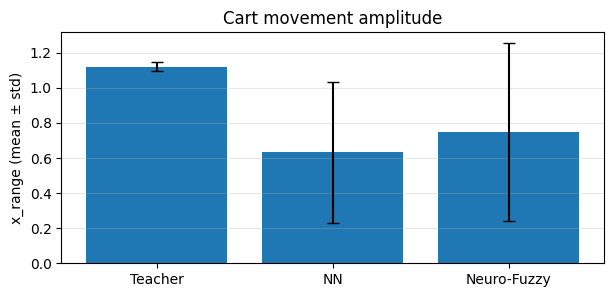

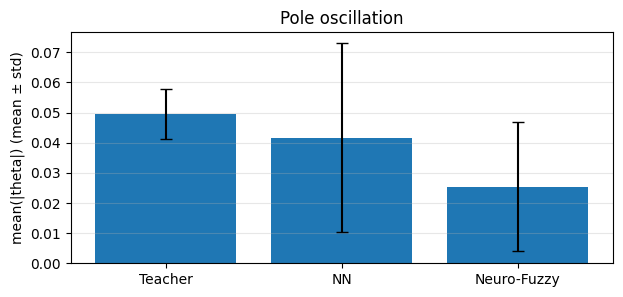

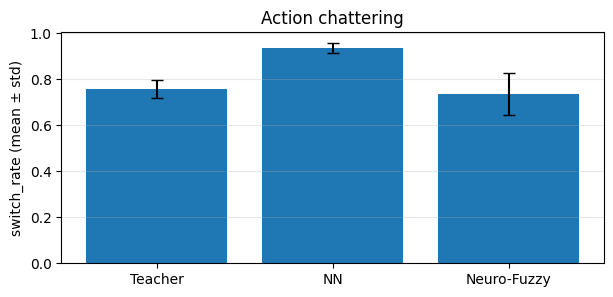

In [ ]:
# Bar charts (means) + error bars (std)
labels = ["Teacher", "NN", "Neuro-Fuzzy"]

means_xr = [tc_xr.mean(), nn_xr.mean(), nf_xr.mean()]
stds_xr  = [tc_xr.std(),  nn_xr.std(),  nf_xr.std()]

means_th = [tc_th.mean(), nn_th.mean(), nf_th.mean()]
stds_th  = [tc_th.std(),  nn_th.std(),  nf_th.std()]

means_sw = [tc_sw.mean(), nn_sw.mean(), nf_sw.mean()]
stds_sw  = [tc_sw.std(),  nn_sw.std(),  nf_sw.std()]

plt.figure(figsize=(7,3))
plt.bar(labels, means_xr, yerr=stds_xr, capsize=4)
plt.ylabel("x_range (mean ± std)")
plt.grid(True, axis="y", alpha=0.3)
plt.title("Cart movement amplitude")
plt.show()

plt.figure(figsize=(7,3))
plt.bar(labels, means_th, yerr=stds_th, capsize=4)
plt.ylabel("mean(|theta|) (mean ± std)")
plt.grid(True, axis="y", alpha=0.3)
plt.title("Pole oscillation")
plt.show()

plt.figure(figsize=(7,3))
plt.bar(labels, means_sw, yerr=stds_sw, capsize=4)
plt.ylabel("switch_rate (mean ± std)")
plt.grid(True, axis="y", alpha=0.3)
plt.title("Action chattering")
plt.show()


## 8. Time-series plots for an illustrative seed
We plot x(t) and |theta(t)| for NN vs Neuro-Fuzzy vs Teacher.

Using seed: 3


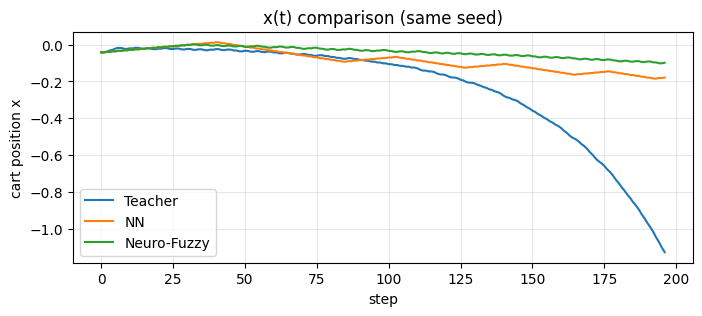

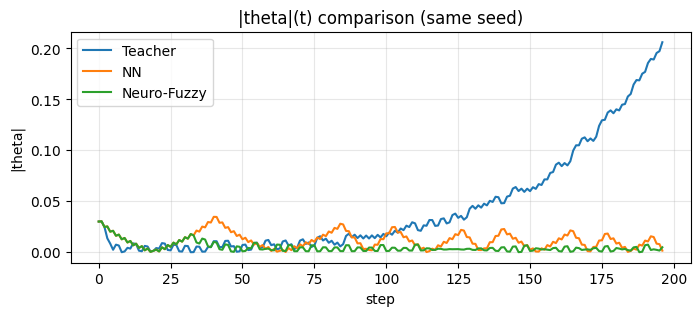

In [ ]:
def rollout_trace(policy_fn, seed=0, max_steps=300):
    env = gym.make("CartPole-v1")
    obs, info = env.reset(seed=int(seed))
    env.action_space.seed(int(seed))
    xs=[float(obs[0])]
    thetas=[abs(float(obs[2]))]
    actions=[]
    steps=0
    for _ in range(max_steps):
        a = policy_fn(obs)
        actions.append(a)
        obs, reward, terminated, truncated, info = env.step(a)
        steps += 1
        xs.append(float(obs[0]))
        thetas.append(abs(float(obs[2])))
        if terminated or truncated:
            break
    env.close()
    return steps, np.array(xs), np.array(thetas), np.array(actions)

# Choose a seed where Neuro-Fuzzy is smoother (smaller x_range and mean|theta|)
BEST_SEED = None
for s in range(200):
    st_n, xs_n, th_n, _ = rollout_trace(nn_policy, seed=s, max_steps=300)
    st_f, xs_f, th_f, _ = rollout_trace(nf_policy, seed=s, max_steps=300)
    if st_f >= 200 and st_n >= 200:
        if (xs_f.max()-xs_f.min()) <= (xs_n.max()-xs_n.min())*0.85 and th_f.mean() <= th_n.mean()*0.92:
            BEST_SEED = s
            break

if BEST_SEED is None:
    BEST_SEED = 0

print("Using seed:", BEST_SEED)

st_t, xs_t, th_t, _ = rollout_trace(teacher_fn, seed=BEST_SEED, max_steps=300)
st_n, xs_n, th_n, _ = rollout_trace(nn_policy, seed=BEST_SEED, max_steps=300)
st_f, xs_f, th_f, _ = rollout_trace(nf_policy, seed=BEST_SEED, max_steps=300)

T = min(st_t, st_n, st_f)

plt.figure(figsize=(8,3))
plt.plot(xs_t[:T], label="Teacher")
plt.plot(xs_n[:T], label="NN")
plt.plot(xs_f[:T], label="Neuro-Fuzzy")
plt.xlabel("step"); plt.ylabel("cart position x")
plt.grid(True, alpha=0.3); plt.legend()
plt.title("x(t) comparison (same seed)")
plt.show()

plt.figure(figsize=(8,3))
plt.plot(th_t[:T], label="Teacher")
plt.plot(th_n[:T], label="NN")
plt.plot(th_f[:T], label="Neuro-Fuzzy")
plt.xlabel("step"); plt.ylabel("|theta|")
plt.grid(True, alpha=0.3); plt.legend()
plt.title("|theta|(t) comparison (same seed)")
plt.show()


## 9. MP4 videos for the same illustrative seed
We export NN and Neuro-Fuzzy videos for the chosen seed.

In [ ]:
VIDEO_STEPS = 250
FPS = 20

def record_mp4(policy_fn, filename, seed=0, n_steps=200, fps=20):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset(seed=int(seed))
    env.action_space.seed(int(seed))
    frames=[]
    for _ in range(n_steps):
        a = policy_fn(obs)
        obs, reward, terminated, truncated, info = env.step(a)
        frames.append(env.render())
        if terminated or truncated:
            break
    env.close()

    fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(frames[0])

    def init():
        im.set_data(frames[0]); return (im,)
    def animate(i):
        im.set_data(frames[i]); return (im,)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames), interval=50, blit=True)
    anim.save(filename, fps=fps)
    plt.close(fig)
    print("Saved:", filename, "frames:", len(frames))

record_mp4(nn_policy, "week7_nn_v5.mp4", seed=BEST_SEED, n_steps=VIDEO_STEPS, fps=FPS)
record_mp4(nf_policy, "week7_neurofuzzy_v5.mp4", seed=BEST_SEED, n_steps=VIDEO_STEPS, fps=FPS)

files.download("week7_nn_v5.mp4")
files.download("week7_neurofuzzy_v5.mp4")


Saved: week7_nn_v5.mp4 frames: 250
Saved: week7_neurofuzzy_v5.mp4 frames: 250


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ✅ Report guidance
In your report, include:
- Bar charts (means ± std) comparing x_range, mean|theta|, switch_rate
- Time-series plots x(t) and |theta|(t) for the illustrative seed
- MP4 videos (NN vs Neuro-Fuzzy)
- Short explanation: why structured Neuro-Fuzzy tends to reduce oscillations
